<a href="https://colab.research.google.com/github/iremakalp/Plant_Disease_Detection/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **1.1. Import Required Libraries**



In [4]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

#### **1.2. Test-Train Data**


In [5]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="/content/drive/MyDrive/Crop past dataset1/train"
test_dir="/content/drive/MyDrive/Crop past dataset1/test"

In [6]:
 #train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*"))
#test file image count
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

15 Classes
2400 Train images
1500 Test images


#### **1.3. ImageDataGenerator**

In [7]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)

In [8]:
input_shape=(224,224,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(224,224),batch_size=32)

Found 2400 images belonging to 15 classes.
Found 1500 images belonging to 15 classes.


#### **1.5. VGG16 Modeli**


In [9]:
def create_Base_model_from_VGG16():
    model = VGG16(
        weights = "imagenet",
        include_top=False,
        input_shape = (224,224, 3) # goruntu boyutu
        )
    for layer in model.layers:
      layer.trainable = False
    return model
create_Base_model_from_VGG16().summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
def add_custom_layers():
    model = create_Base_model_from_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    # creating the final model
    final_model = tf.keras.models.Model(
        inputs = model.input,
        outputs = predictions)

    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return final_model

add_custom_layers().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir, # same directory as training data
                       target_size=(224, 224),
                       batch_size=16)

Found 1500 images belonging to 15 classes.


In [12]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [15]:
model_from_vgg16 = add_custom_layers()
history2 = model_from_vgg16.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    use_multiprocessing=False,
    shuffle=True
    )

Epoch 1/25
75/75 [==============================] - 67s 878ms/step - loss: 2.3723 - accuracy: 0.3808 - val_loss: 1.2206 - val_accuracy: 0.5807 - lr: 0.0010
Epoch 2/25
75/75 [==============================] - 82s 1s/step - loss: 1.0477 - accuracy: 0.6508 - val_loss: 0.7768 - val_accuracy: 0.7587 - lr: 0.0010
Epoch 3/25
75/75 [==============================] - 65s 872ms/step - loss: 0.8116 - accuracy: 0.7208 - val_loss: 0.6376 - val_accuracy: 0.8007 - lr: 0.0010
Epoch 4/25
75/75 [==============================] - 65s 866ms/step - loss: 0.6264 - accuracy: 0.7892 - val_loss: 0.4961 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 5/25
75/75 [==============================] - 81s 1s/step - loss: 0.5321 - accuracy: 0.8217 - val_loss: 0.5321 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 6/25
75/75 [==============================] - 65s 868ms/step - loss: 0.4530 - accuracy: 0.8462 - val_loss: 0.3666 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 7/25
75/75 [==============================] - 66s 883ms/step - l

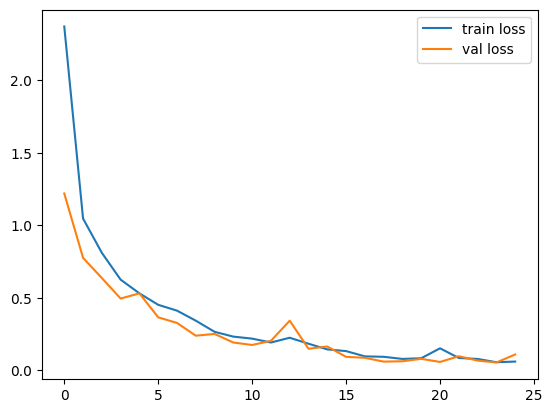

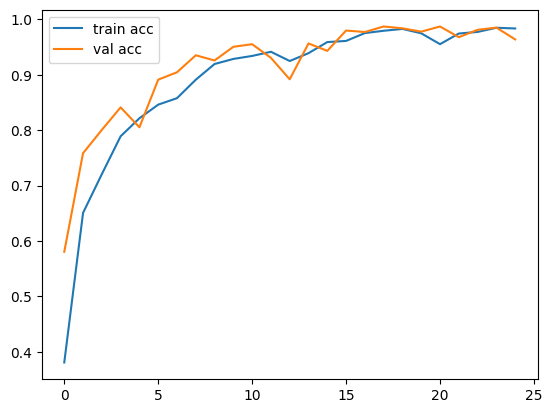

<Figure size 640x480 with 0 Axes>

In [17]:
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [21]:
model_from_vgg16.save('/content/drive/MyDrive/Colab Notebooks/Model/model_VGG16.h5')

###  Test

#### **2.2. VGG16 Model**

In [22]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_vgg16=load_model('/content/drive/MyDrive/Colab Notebooks/Model/model_VGG16.h5')

1/1 [==============================] - 0s 18ms/step
Cashew_anthracnose


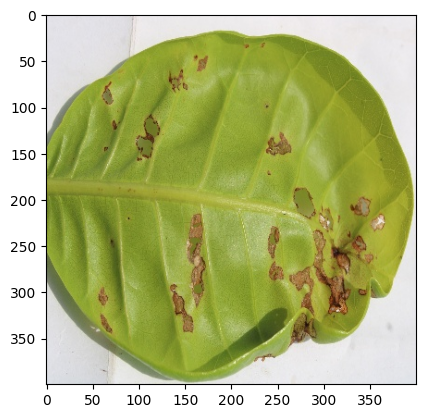

In [24]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='/content/drive/MyDrive/Crop past dataset1/test/Cashew_anthracnose/anthracnose1004_.jpg'
result_vgg16 = model_vgg16.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_vgg16,axis=1)
print(classes[classresult[0]])